# DM872 A Cutting Plane Approach for the Traveling Salesman Problem

## Traveling Salesman Problem

Part of this script is taken from the very nice tutorial by Peter Norvig:
http://nbviewer.jupyter.org/url/norvig.com/ipython/TSP.ipynb

Consider the [Traveling Salesperson Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem):

> Given a set of cities and the distances between each pair of cities, what is the shortest possible tour that visits each city exactly once, and returns to the starting city?

## Representing an instance of the problem

The only thing that matters about cities is the distance between them. We will ignore the fully general TSP where distances can be defined in any arbitrary way and concentrate on an important special case, 
the *Euclidean TSP*, where the distance between any two cities is the Euclidean distance, the straight-line distance between points in a two-dimensional plane. 
So a city can be represented by a two-dimensional point: a pair of $x$ and $y$ coordinates in the Cartesian plane.
Python already has the two-dimensional point as a built-in numeric data type, 
but in a non-obvious way: as complex numbers, which inhabit the two-dimensional (real $\times$ imaginary) plane. We will use those but you will not have to care about this aspect as all functions to handle data are made available to you.

We will work with three predetermined, historical instances, `dantzig42.dat berlin52.dat bier127.dat`, and with randomly generated instances.
You find the three instances in the `data` directory of the git repository for this Sheet. 
In the file `tsputil.py` from `src/` you will find the functions to read the instances from the files and to generate instances at random.  
The constructor function `City`, creates a city object, so that `City(300, 0)` creates a city with x-coordinate of `300` and y-coordinate of `0`. 
Then, `distance(A, B)` will be a function that uses the $x$ and $y$ coordinates to compute the distance between cities `A` and `B`.

Let's import the files:
```python
from tsputil import *
```

In [2]:
import pyomo.environ as po
from collections import OrderedDict

%run src/tsputil.py 
%matplotlib inline

We can then generate an instance of random points with the function `Cities(n,seed)`. The function returns a frozen set because these are the input data and cannot be modified. We plot the instance with `plot_situation`. When you generate an instance make sure that you use a seed number different from the one of other groups working at this project.

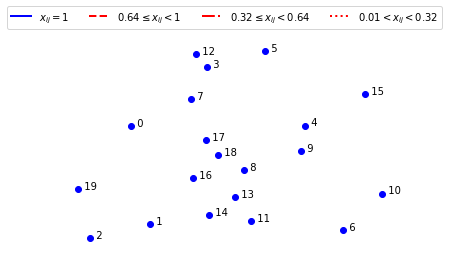

In [2]:
ran_points = Cities(n=20,seed=25)
plot_situation(ran_points)

Alternatively, we can read the `dantiz42.dat` instance which represents locations in USA.

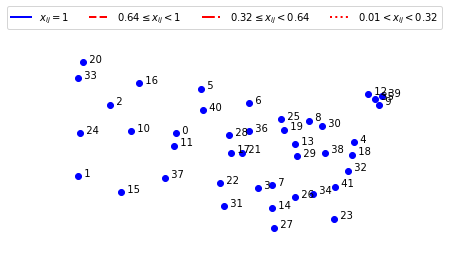

In [3]:
dantzig42 = read_instance("data/dantzig42.dat")
plot_situation(dantzig42)

## Dantzig, Fulkerson and Johnson (DFJ) Formulation

Consider the following formulation of the *symmetric traveling salesman
problem* due to Dantzig, Fulkerson and Johnson, 1954 (DFJ) that we have
been discussing during the course. Let $V=\{0..n-1\}$ be the set of nodes
and $E$ the set of edges. Let $E(S)$ be the set of edges induced by the
subset of vertices $S$ and $\delta(v)$ the set of edges in the cut
$(v,V\setminus\{v\})$. (We will assume that the instance is symmetric and that an edge between two nodes $i$ and $j$ is present in $E$ only in the form $ij$, if $j>i$, or $ji$, if $ j < i$.) 
$$\begin{aligned}
\text{(TSPIP)}\quad \min\; & \sum c_{ij} x_{ij} \\
\text{s.t.}\;&\sum_{ij \in \delta(i)} x_{ij}+\sum_{ji \in \delta(i)}x_{ji}=2 \text{ for all } i \in V\\
\label{subtour}&\sum_{ij \in E(S)} x_{ij} \leq |S|-1 \text{ for all } \emptyset \subset S\subset V, 2 \leq |S| \leq n-1\\
&x_{ij} \in \{0,1\} \text{ for all } {ij} \in E\end{aligned}$$

We can generate all subsets of the set of 20 randomly generated cities as follows: 

In [4]:
from itertools import chain, combinations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

subtours = list(powerset(range(len(ran_points))))
# The first element of the list is the empty set and the last element is the full set, hence we remove them.
subtours = subtours[1:(len(subtours)-1)]

### Task 1
Implement the DFJ formulation in the model below and solve your random instance:

In [5]:
def solve_tsp(points, subtours=[], vartype=po.Binary, solver="glpk", silent=True):
    points=list(points)
    V = range(len(points))
    E = [(i,j) for i in V for j in V if i<j] # complete graph

    m = po.ConcreteModel("TSP0")
    
    ######### BEGIN: Write here your model for Task 1
    ## Vars
    
    ## Objective
    
    ## Constraints
    
    ######### END
    
    m.write("tsplp.lp")
    results = po.SolverFactory(solver).solve(m, tee=(not silent))
    #results.write()
    
    if str(results.Solver.status) == 'ok':
        print('The optimal objective is %g' % m.value())
        return {e: po.value(m.x[e]) for e in E}
    else:
        print("Something wrong in solve_tsp")
        exit(0)

If we try to solve the small instance on 20 cities with this model, ie:
```python
solve_tsp(ran_points, subtours)
```
we get out of memory (you can be more lucky but if so try increasing your instance with a few more cities).

## A Cutting Plane Approach 

The number of subtour elimination constraints in the DFJ formulation can be huge ($2^n$) and even though we can
remove half of those due to symmetries, there are still exponentially
many. A way to deal with large families of constraints is to introduce
them only when needed. This idea is similar to the cutting plane
algorithm that we saw in the intro classes.
We start by solving the relaxed version of (TSPIP) obtained by removing
the integrality constraints and the exponentially many subtour
elimination constraints. We dub this relaxation TSPLP$_0$. Let $x^*$ be
the optimal solution of TSPLP$_0$.


### Task 2
Implement the new function `solve_tsp(points, subtours=[])` that solves the relaxed version TSPLP$_0$ and solve your random instance with 20 points. Inspect the plot of the solution obtained. 
```python
tsplp0 = solve_tsp(ran_points, subtours=[], vartype=po.NonNegativeReals)
plot_situation(ran_points, tsplp0)
```
Describe what you observe. Are all variables integer? Is the matrix TUM? Why? Is the solution a tour? Is the solution matching your expectations?

### Task 3 
Detect by visual inspection some subtour inequalities to add to TSPLP0. List those subtours in the subtour argument of the function `solve_tsp` and solve the new problem TSPLP$_1$=TSPLP$_0 \cup c$, where $c$ is the constraint added.
Report the visualization produced by `plot_situation` on the new solution. Is it a tour? If not iterate this procedure until you cannot find anymore subtours. Show your last solution and comment on it. 

### Task 4
We can automatize the manual process described above. 
Let $V'=V\setminus\{0\}$ and $E'=E\setminus\{\delta(0)\}$. A set
$S\subseteq V'$ that contains a vertex $k$ forms a subtour in $x^*$ if
$$\sum_{e=ij \in E'(S)} x_e^* > |S \setminus \{k\} |=|S|-1.$$ 

We can find the subtour elimination constraint that is most violated by $x^*$ by solving
the following *separation problem* for $k=\{1..n-1\}$. Let’s represent the
unknown set $S \subseteq V'$ by binary variables $z$ with $z_i=1$ if
$i \in S$ then the separation problem for $k=\{1..n-1\}$ is

$$ (SEP) \quad \xi_k=\max \left\{ \sum_{e=ij\in E':i < j} x^*_e z_i z_j - \sum_{i
  \in V' \setminus \{k\}} z_i : z \in \mathbb{B}^n, z_k=1\right\} $$ 

If $ \xi_k > 0 $ for some $k$ then the solution $z^*$ of SEP gives a subtour
$S$, containing $k$, whose corresponding subtour elimination constraint
in TSPIP is violated by $x^*$. We insert this constraint in TSPLP$_0$
and solve the new problem TSPLP$_1$.

Rewrite the (SEP) problem for some $k$ as an integer linear program and report the mathematical model in your answers.

### Task 5
Implement your model in the function `solve_separation(points, x_star, k)` below and solve the **LP relaxation of the (SEP) problem** to separate the optimal solution $x^*$ of TSPLP$_0$.

In [6]:
def solve_separation(points, x_star, k, vartype=po.Reals, solver="glpk", silent=True):
    points = list(points)
    V = list(range(len(points)))
    Vprime = list(range(1, len(points)))
    E = [(i, j) for i in V for j in V if i < j]
    Eprime = [(i, j) for i in Vprime for j in Vprime if i < j]

    m = po.ConcreteModel("SEP")
   
    # BEGIN: Write here your model for Task 5
   
    
    # END
    results = po.SolverFactory(solver).solve(m, tee=(not silent))
    
    if str(results.Solver.status) == 'ok':
        print(('Separation problem solved for k=%d, solution value %g' % (k, m.value())))
        # BEGIN: Write here the subtour found from the solution of the model
        # it must be a list of points
        subtour = []
        subtour = list(filter(lambda i: m.z[i]() >= 0.99, Vprime))
        # END
        return m.value(), subtour
    else:
        print("Something wrong in solve_separation")
        exit(0)
    

Try your implementation of `solve_separation` on your previous TSPLP$_0$ solution. Do you get the expected answer?

### Task 6
The following procedure `cutting_plane_alg` implements the cutting plane algorithm that uses your implementation of `solve_tsp` and `solve_separation`.
Finish the implementation of the function. That is: add the condition for the
    presence of violated inequalities. 

In [1]:
def cutting_plane_alg(points):
    Vprime = range(1,len(points))
    subtours = []
    found = True
    while found:
        lpsol = solve_tsp(points, subtours, vartype=po.Reals)
        plot_situation(points, lpsol)
        found = False
        tmp_subtours = []
        best_val = float('-inf')
        for k in Vprime:
            value, subtour = solve_separation(points,lpsol,k,vartype=po.Reals, silent=True)
            best_val = value if value > best_val else best_val
            ######### BEGIN: write here the condition. Include a tollerance
            if False: 
            ######### END
                found = True
                tmp_subtours += [subtour]
        subtours += tmp_subtours
        print('*'*60)
        print("********** Subtours found: ",tmp_subtours," with best value : ",best_val)
        print('*'*60)
    plot_situation(points, lpsol)
    return lpsol 

Run the cutting plane algorithm
    thus implemented until termination. Report the plot of the last
    solution found by solving the TSPLP$_n$ problem, where $n$ is the
    number of iterations in which violated inequalities were found. Is
    the solution optimal?

### Task 7 
Reflecting upon the process implemented you may wonder whether we
    are gaining anything in efficiency. After all we circumvented having
    to solve the original integer programming formulation of the TSP by
    having to solve many separation problems, which are in principle all
    integer programming problems and hence possibly hard to solve. It
    turns out that the SEP problems are actually solvable efficiently.
    In task 5, you were given the tip to implement the LP relaxation of
    the SEP problem. Why are the solutions to SEP always integer? It
    turns out that the SEP corresponds to one problem treated during
    the course. Which one? In efficient implementations the SEP problem
    is solved by specialized algorithms for this problem. \[Hint: It may
    help to consider the other way to formulate subtour elimination
    constraints, that is, cut-set constraints.\]

### Task 8 
In task 6, you run the cutting plane algorithm until no cutting
    plane can be found anymore. Is this cutting plane algorithm enough
    to solve your instance to optimality? What about the general case on
    any arbitrary instance? Write your considerations and conclusions.
    \[Hint: try the whole procedure on the instances `dantzig42.dat` and
    `dantzig42.dat` to see what happens in the general case. Report the
    final plots on these instance.\]

### Task 9
Provide the length of the optimal tour of your problem on 20 nodes.

### Task 10

Already an instance on 127 vertices is challenging for
    our implementation. Try your cutting plane procedure on the instance
    `bier127.dat`, which asks to find the shortest tour among the 127
    biergardens in Augsburg, Bavaria. You will have to comment the line
    for plotting at each iteration, since it is inefficient. Moreover it
    might be convenient not to wait for all $k$s to be evaluated but to
    insert a cut as soon as one is found.

### Task 11

Experiment ideas: 
- combine the DFJ cutting plane procedure with integrality constraints 
- solve the separation problems in a more efficient way, for example, with network flow algorithms.